###Imports

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import sentiment
from bs4 import BeautifulSoup
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#!tar -xvf '/content/drive/MyDrive/Dataset/aclImdb_v1.tar.gz'

In [3]:
def read_imdb(data_dir):
    data = []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir,label)
        for file in os.listdir(folder_name):
          #print(file)
          with open(os.path.join(folder_name, file), 'rb') as f:
            #print(f.name.split('/')[5].split('.')[0])
            fname = f.name.split('/')[5].split('.')[0].split('_')
            review = f.read().decode('utf-8').replace('\n', '')
            sentiment = 1 if label == 'pos' else -1

            data_tuple = (fname[0],fname[1],sentiment,review)
            data.append(data_tuple)
            #break
    return data 

def generate_csv(data,filename):
  np.savetxt(filename, [p for p in zip(data[0], data[1], data[2],data[3])], delimiter='|', fmt='%s')

TRAIN_PATH='/content/aclImdb/train/'
TEST_PATH='/content/aclImdb/test/'

train = read_imdb(TRAIN_PATH)
test = read_imdb(TEST_PATH)

In [4]:
df_train = pd.DataFrame(train, columns =['id','rating','label','review'])
df_test = pd.DataFrame(test, columns =['id','rating','label','review'])

df_train.head(3)

,id,rating,label,review
0,9055,10,1,This is an amazing movie and all of the actors...
1,11344,7,1,Pufnstuf is what it is. I saw this in the cine...
2,362,10,1,In the year 1985 (my birth year) Steven Spielb...


### Data Cleaning

* Words like [movie, film, character, one, story, time, really, make ] are frequent in both the sentiments (found during EDA), thus they do not help in classification. 
* We will ignore these words during data cleaning.

In [5]:
IGNORE_WORDS = ['br br', 'film', 'movie', 'one', 'character', 'time', 'make', 'even', 'show', 'story', 'way', 'see', 'much', 'think', 'scene', 'well', 'great', 'good', 'life', 'really', 'people', 'love', 'work', 'little', 'still', 'look', 'know', 'seem', 'play', 'end', 'made', 'many', 'find', 'first', 'two', 'man', 'thing', 'give', 'say', 'now', 'will', 'take', 'lot', 'come', 'part', 'actor', 'plot', 'though', 'director', 'performance', 'role', 'watch', 'real', 'fact', 'something', 'never', 'new', 'set', 'actually', 'want', 'another', 'go', 'right', 'got', 'going', 'rather', 'back', 'thought', 'girl', 'funny', 'better', 'almost', 'get', 'kid', 'without', 'acting']
def clean_data(review):
    #print("Org : " , review)

    #HTML tag
    raw_text=BeautifulSoup(review, 'html').get_text()
    #print("Html : ",raw_text)

    #urls
    raw_text = re.sub(r"(www|http:|https:)+[\S]+[\w]", "", raw_text)
    #print("Links : ",raw_text)
    
    #non English character
    letters = re.sub('[^a-zA-Z]', ' ', raw_text)
    #print("Non English : ",letters)

    #lowercase
    tokens = letters.lower().split() 

    #filter ignore_words
    #tokens = [token for token in tokens if token not in IGNORE_WORDS] 
    #print(tokens)

    #stopwords and stemming
    stopwords = nltk.corpus.stopwords.words('english')
    wn = nltk.WordNetLemmatizer()
    words = [wn.lemmatize(w) for w in tokens if w not in stopwords ]
    
    #ignore_words
    IGNORE_WORDS_LEM = [wn.lemmatize(w).lower() for w in IGNORE_WORDS]
    words = [w for w in words if w not in IGNORE_WORDS_LEM]

    #ps = nltk.PorterStemmer()
    #words = [ps.stem(w) for w in tokens if w not in stopwords]
    
    #print("Tokens : ",words)
    return words

In [6]:
clean_data("film! this is test aaa <br> https://urls.com, is good with <b>technology</b>! Tests failed? See movies one two")

['test', 'aaa', 'technology', 'test', 'failed']

In [7]:
X_train =  df_train['review'].apply(clean_data)
y_train = df_train['label']
print(X_train.shape, y_train.shape)

(25000,) (25000,)


In [8]:
X_test = df_test['review'].apply(clean_data)
y_test = df_test['label']
print(X_test.shape, y_test.shape)

(25000,) (25000,)


In [9]:
def generate_vocab(data): 
  vocab = set()
  for clean_x in data : #cleaned_data
    for word in clean_x :
      #print(word)
      vocab.add(word)
      #break
  return sorted(vocab)

In [10]:
vocab1 = generate_vocab(X_train)
#print("Vocab : ",vocab1)
print("Vocab Length of Train set : ", len(vocab1))

Vocab Length of Train set :  66314


In [11]:
vocab2 = generate_vocab(X_test)
print("Vocab Length of Test set : ", len(vocab2))

Vocab Length of Test set :  65534


###  Sentiment Analysis

In [27]:
result = []
seed = 2
rf_est = 1000

def train_model(train_feat, y_train, model):
   model.fit(train_feat, y_train)
   return model

def predict(test_feat, y_test, model, title):
     
    #Test
    y_pred = model.predict(test_feat)
    
    #Performance
    #ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    plt.title(title)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    #AUC
    roc_auc = auc(fpr, tpr)
    print('AUC:', roc_auc)
    
    #Classification Report
    print("Report \n",classification_report(y_test,y_pred))

    #Confusion Matrix
    cf_matrix = confusion_matrix(y_test,y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

    #Accuracy
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:",acc)

    result.append( [title.split(":")[0].strip(), title.split(":")[1].strip(), title.split(":")[2].strip(), acc])

####Bag of Words

In [21]:
bow_vectorizer = CountVectorizer(analyzer = "word", min_df=10, tokenizer = lambda x: x, lowercase=False,  preprocessor = None, stop_words = None)

train_feat = bow_vectorizer.fit_transform(X_train).toarray()
test_feat = bow_vectorizer.transform(X_test).toarray()

print("Train",train_feat.shape)
print("Test",test_feat.shape)

Train (25000, 16249)
Test (25000, 16249)


##### Naive Bayes

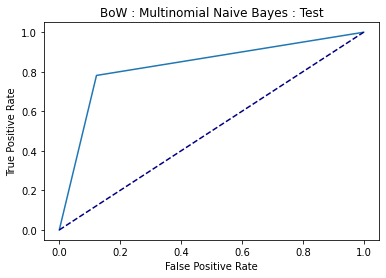

AUC: 0.82964
Report 
               precision    recall  f1-score   support

          -1       0.80      0.88      0.84     12500
           1       0.86      0.78      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



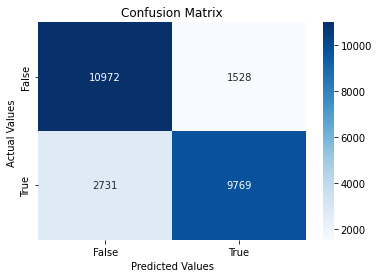

Accuracy: 0.82964


In [15]:
model_mnb_bow = train_model(train_feat, y_train, MultinomialNB())
predict(test_feat, y_test, model_mnb_bow, "BoW : Multinomial Naive Bayes : Test")

##### Decision Tree

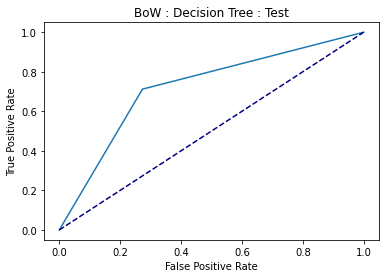

AUC: 0.71944
Report 
               precision    recall  f1-score   support

          -1       0.72      0.73      0.72     12500
           1       0.72      0.71      0.72     12500

    accuracy                           0.72     25000
   macro avg       0.72      0.72      0.72     25000
weighted avg       0.72      0.72      0.72     25000



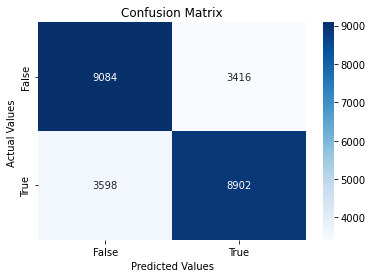

Accuracy: 0.71944


In [20]:
model_dt_bow = train_model(train_feat, y_train, DecisionTreeClassifier(random_state=seed))
predict(test_feat, y_test, model_dt_bow, "BoW : Decision Tree : Test")

#####Random Forest

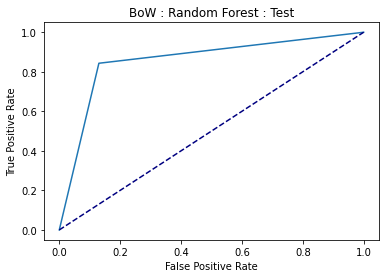

AUC: 0.85652
Report 
               precision    recall  f1-score   support

          -1       0.85      0.87      0.86     12500
           1       0.87      0.84      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



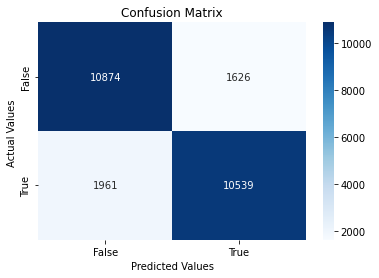

Accuracy: 0.85652


In [25]:
model_rf_bow = train_model(train_feat, y_train, RandomForestClassifier(n_estimators = rf_est) )
predict(test_feat, y_test, model_rf_bow, "BoW : Random Forest : Test")

In [26]:
print("Summary")
result

Summary


[['BoW', 'Multinomial Naive Bayes', 'Test', 0.82964],
 ['BoW', 'Decision Tree', 'Test', 0.71944],
 ['BoW', 'Random Forest', 'Test', 0.85652]]

####TFIDF

In [22]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, use_idf=True) 
tfidf = tfidf_vectorizer.fit_transform(X_train)
test_tfidf = tfidf_vectorizer.transform(X_test)

print("Train",tfidf.shape)
print("Test",test_tfidf.shape)

Train (25000, 66314)
Test (25000, 66314)


#####Naive Bayes

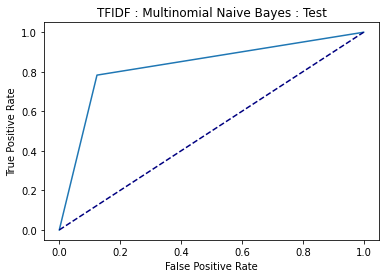

AUC: 0.8296400000000002
Report 
               precision    recall  f1-score   support

          -1       0.80      0.88      0.84     12500
           1       0.86      0.78      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



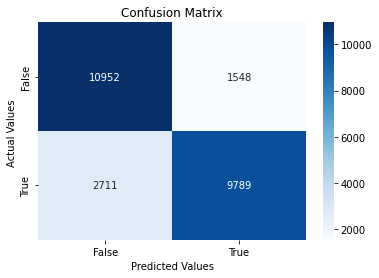

Accuracy: 0.82964


In [29]:
model_mnb_tf = train_model(tfidf, y_train, MultinomialNB())
predict(test_tfidf, y_test, model_mnb_tf, "TFIDF : Multinomial Naive Bayes : Test")

##### Decision Tree

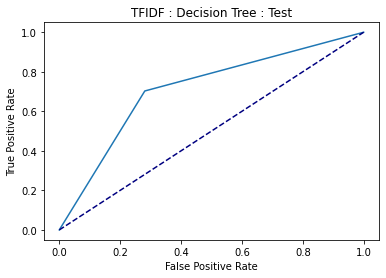

AUC: 0.7109599999999999
Report 
               precision    recall  f1-score   support

          -1       0.71      0.72      0.71     12500
           1       0.71      0.70      0.71     12500

    accuracy                           0.71     25000
   macro avg       0.71      0.71      0.71     25000
weighted avg       0.71      0.71      0.71     25000



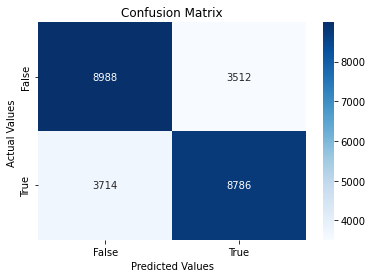

Accuracy: 0.71096


In [31]:
model_df_tf = train_model(tfidf, y_train, DecisionTreeClassifier(random_state=seed) )
predict(test_tfidf, y_test, model_df_tf, "TFIDF : Decision Tree : Test")

#####Random Forest

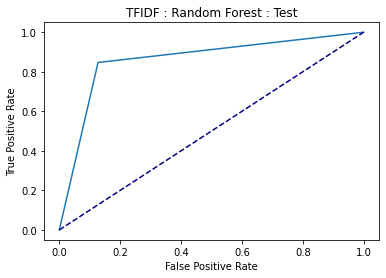

AUC: 0.8598399999999999
Report 
               precision    recall  f1-score   support

          -1       0.85      0.87      0.86     12500
           1       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



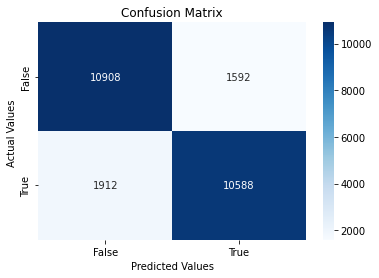

Accuracy: 0.85984


In [33]:
model_rf_tf = train_model(tfidf, y_train, RandomForestClassifier(n_estimators = rf_est) )
predict(test_tfidf, y_test, model_rf_tf, "TFIDF : Random Forest : Test")

In [15]:
print("TFIDF Summary")
result

TFIDF Summary


[['TFIDF', 'Multinomial Naive Bayes', 'Test', 0.82964],
 ['TFIDF', 'Decision Tree', 'Test', 0.71096],
 ['TFIDF', 'Random Forest', 'Test', 0.85984]]

#### Testing Summary

In [34]:
print("Summary")
dfr = pd.DataFrame(result, columns =['Vector', 'Model',"Dataset", 'Accuracy']) 
print(dfr)

Summary
  Vector                    Model Dataset  Accuracy
0    BoW  Multinomial Naive Bayes    Test   0.82964
1    BoW            Decision Tree    Test   0.71944
2    BoW            Random Forest    Test   0.85652
3  TFIDF  Multinomial Naive Bayes    Test   0.82964
4  TFIDF            Decision Tree    Test   0.71096
5  TFIDF            Random Forest    Test   0.85984


In [ ]:
##Uncomment to load or save your model
#import pickle
#pickle.dump(model_rf_tf, open("rftf.sav", 'wb'))
#model_rf_tf = pickle.load(open("rftf.sav", 'rb'))

### ANALYSIS OF TSR

####Load Data and Extract Features

In [16]:
TMR_PATH = '/content/IMDb_TSR_Reviews.csv' 

df = pd.read_csv(TMR_PATH, usecols = ['Reviews','Scores'])
df. rename(columns = {'Reviews':'review', 'Scores':'rating'}, inplace = True)
df.head()

,review,rating
0,Why do I want to write the 234th comment on Th...,10.0
1,The Shawshank Redemption is written and direct...,10.0
2,"In its Oscar year, Shawshank Redemption (writt...",10.0
3,This movie is not your ordinary Hollywood flic...,10.0
4,I'm trying to save you money; this is the last...,10.0


In [17]:
def generate_label(score):
    if score > 6 :
      return 1 #positive
    elif score > 4 :
      return 0 #neutral
    else : 
      return -1 #negative
    
#Assigning label to the dataset
df['label'] = df.apply(lambda x: generate_label(x['rating']), axis=1)
df.head(5)

,review,rating,label
0,Why do I want to write the 234th comment on Th...,10.0,1
1,The Shawshank Redemption is written and direct...,10.0,1
2,"In its Oscar year, Shawshank Redemption (writt...",10.0,1
3,This movie is not your ordinary Hollywood flic...,10.0,1
4,I'm trying to save you money; this is the last...,10.0,1


In [18]:
df_tsr = df[(df['label'] != 0) ]
X_tsr = df_tsr['review'].apply(clean_data)
y_tsr = df_tsr['label']

In [23]:
#Generate Features - Bow and TFIDF
tsr_feat = bow_vectorizer.transform(X_tsr).toarray()
tsr_tfidf = tfidf_vectorizer.transform(X_tsr)

In [24]:
print(tsr_feat.shape)
print(tsr_tfidf.shape)

(9829, 16249)
(9829, 66314)


####Naive Bayes

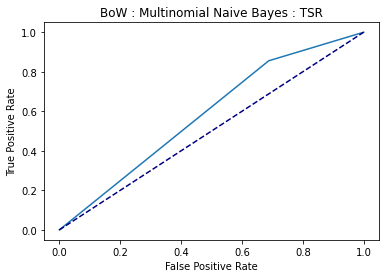

AUC: 0.583764480897883
Report 
               precision    recall  f1-score   support

          -1       0.17      0.31      0.22       824
           1       0.93      0.86      0.89      9005

    accuracy                           0.81      9829
   macro avg       0.55      0.58      0.55      9829
weighted avg       0.87      0.81      0.84      9829



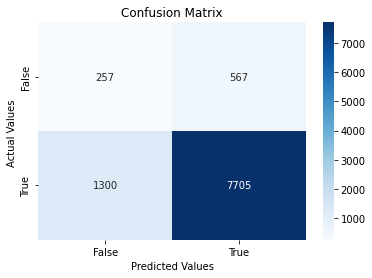

Accuracy: 0.8100518872723573


In [29]:
predict(tsr_feat, y_tsr, model_mnb_bow, "BoW : Multinomial Naive Bayes : TSR")

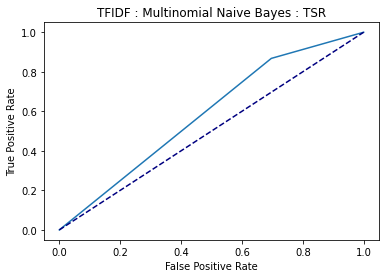

AUC: 0.5855691013083346
Report 
               precision    recall  f1-score   support

          -1       0.17      0.30      0.22       824
           1       0.93      0.87      0.90      9005

    accuracy                           0.82      9829
   macro avg       0.55      0.59      0.56      9829
weighted avg       0.87      0.82      0.84      9829



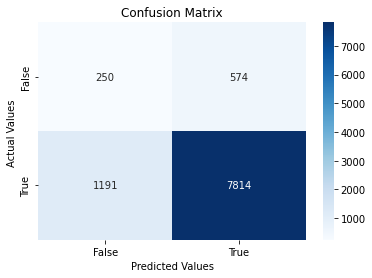

Accuracy: 0.8204293417438193


In [41]:
predict(tsr_tfidf, y_tsr, model_mnb_tf, "TFIDF : Multinomial Naive Bayes : TSR")

####Decision Tree

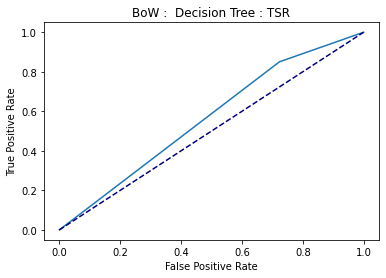

AUC: 0.5635577322199641
Report 
               precision    recall  f1-score   support

          -1       0.14      0.28      0.19       824
           1       0.93      0.85      0.89      9005

    accuracy                           0.80      9829
   macro avg       0.54      0.56      0.54      9829
weighted avg       0.86      0.80      0.83      9829



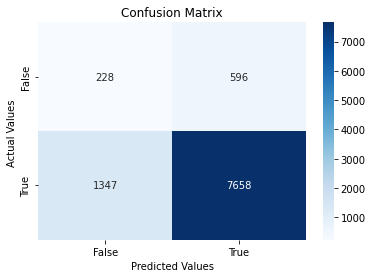

Accuracy: 0.802319666293621


In [31]:
predict(tsr_feat, y_tsr, model_dt_bow, "BoW :  Decision Tree : TSR")

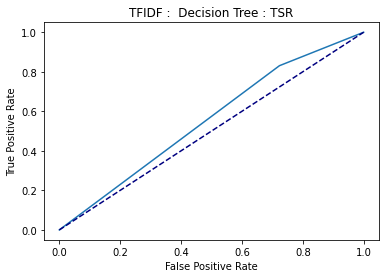

AUC: 0.5537298588162994
Report 
               precision    recall  f1-score   support

          -1       0.13      0.28      0.18       824
           1       0.93      0.83      0.88      9005

    accuracy                           0.78      9829
   macro avg       0.53      0.55      0.53      9829
weighted avg       0.86      0.78      0.82      9829



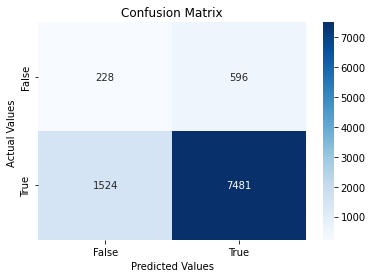

Accuracy: 0.7843117305931427


In [37]:
predict(tsr_tfidf, y_tsr, model_df_tf, "TFIDF :  Decision Tree : TSR")

####Random Forest

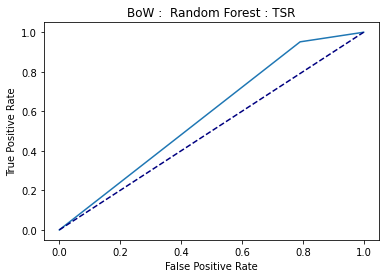

AUC: 0.5801046344263974
Report 
               precision    recall  f1-score   support

          -1       0.28      0.21      0.24       824
           1       0.93      0.95      0.94      9005

    accuracy                           0.89      9829
   macro avg       0.61      0.58      0.59      9829
weighted avg       0.88      0.89      0.88      9829



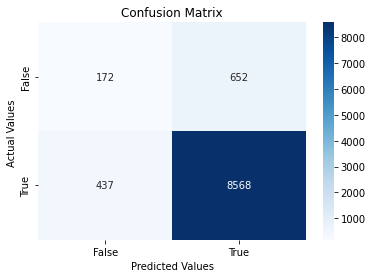

Accuracy: 0.8892054125546851


In [33]:
predict(tsr_feat, y_tsr, model_rf_bow, "BoW :  Random Forest : TSR")

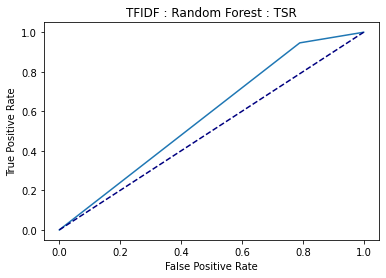

AUC: 0.5781017692436241
Report 
               precision    recall  f1-score   support

          -1       0.26      0.21      0.23       824
           1       0.93      0.95      0.94      9005

    accuracy                           0.88      9829
   macro avg       0.60      0.58      0.59      9829
weighted avg       0.87      0.88      0.88      9829



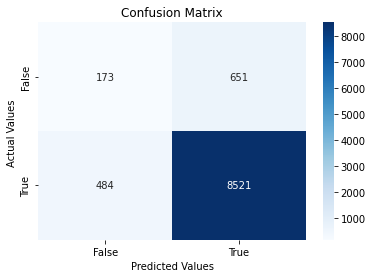

Accuracy: 0.8845253840675552


In [35]:
predict(tsr_tfidf, y_tsr, model_rf_tf, "TFIDF : Random Forest : TSR")

#### TSR Summary

In [42]:
print("Summary")
dfr = pd.DataFrame(result, columns =['Vector', 'Model',"Dataset", 'Accuracy']) 
print(dfr)

Summary
  Vector                    Model Dataset  Accuracy
0    BoW  Multinomial Naive Bayes     TSR  0.810052
1    BoW            Decision Tree     TSR  0.802320
2    BoW            Random Forest     TSR  0.889205
3  TFIDF            Random Forest     TSR  0.884525
4  TFIDF            Decision Tree     TSR  0.784312
5  TFIDF  Multinomial Naive Bayes     TSR  0.820429
